In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
stock_symbol = 'LT.NS'
stock_data = yf.download(stock_symbol,  period="max")

[*********************100%%**********************]  1 of 1 completed


In [5]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-07-01,40.111111,40.724445,40.111111,40.435555,30.889935,3709080
2002-07-02,40.555553,40.933334,40.444443,40.533333,30.964630,2500024
2002-07-03,40.688889,40.755554,40.022221,40.080002,30.618320,1910772
2002-07-04,40.244446,40.377777,39.835556,39.924442,30.499479,1515924
2002-07-05,39.799999,40.222221,39.799999,40.022221,30.574169,1038928
...,...,...,...,...,...,...
2024-04-25,3616.100098,3666.000000,3611.600098,3652.300049,3652.300049,2420380
2024-04-26,3652.000000,3660.899902,3585.000000,3605.199951,3605.199951,1973113
2024-04-29,3606.100098,3649.899902,3605.199951,3634.300049,3634.300049,1396979


In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


stock_data.reset_index(inplace=True)

# Extract the 'Date' and 'Close' columns
data = stock_data[['Date', 'Close']].copy()

In [9]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Function to create dataset
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back)])
        y.append(data[i + look_back, 0])  # Close price is the label (index 0)
    return np.array(X), np.array(y)

# Create dataset with look-back window
look_back = 60  # Adjust this window size as needed
X, y = create_dataset(scaled_data, look_back)

# Reshape input data for LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [10]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [11]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X, y, epochs=50, batch_size=32)

Epoch 1/50
168/168 [==============================] - 11s 12ms/step - loss: 0.0032
Epoch 2/50
168/168 [==============================] - 2s 12ms/step - loss: 0.0010
Epoch 3/50
168/168 [==============================] - 2s 12ms/step - loss: 8.3197e-04
Epoch 4/50
168/168 [==============================] - 2s 12ms/step - loss: 7.8534e-04
Epoch 5/50
168/168 [==============================] - 2s 13ms/step - loss: 6.9690e-04
Epoch 6/50
168/168 [==============================] - 2s 14ms/step - loss: 6.5486e-04
Epoch 7/50
168/168 [==============================] - 2s 12ms/step - loss: 6.0829e-04
Epoch 8/50
168/168 [==============================] - 2s 12ms/step - loss: 5.7298e-04
Epoch 9/50
168/168 [==============================] - 2s 12ms/step - loss: 5.8221e-04
Epoch 10/50
168/168 [==============================] - 2s 12ms/step - loss: 5.3203e-04
Epoch 11/50
168/168 [==============================] - 2s 14ms/step - loss: 5.1476e-04
Epoch 12/50
168/168 [==============================] - 2s 1

1/1 [==============================] - 0s 25ms/step


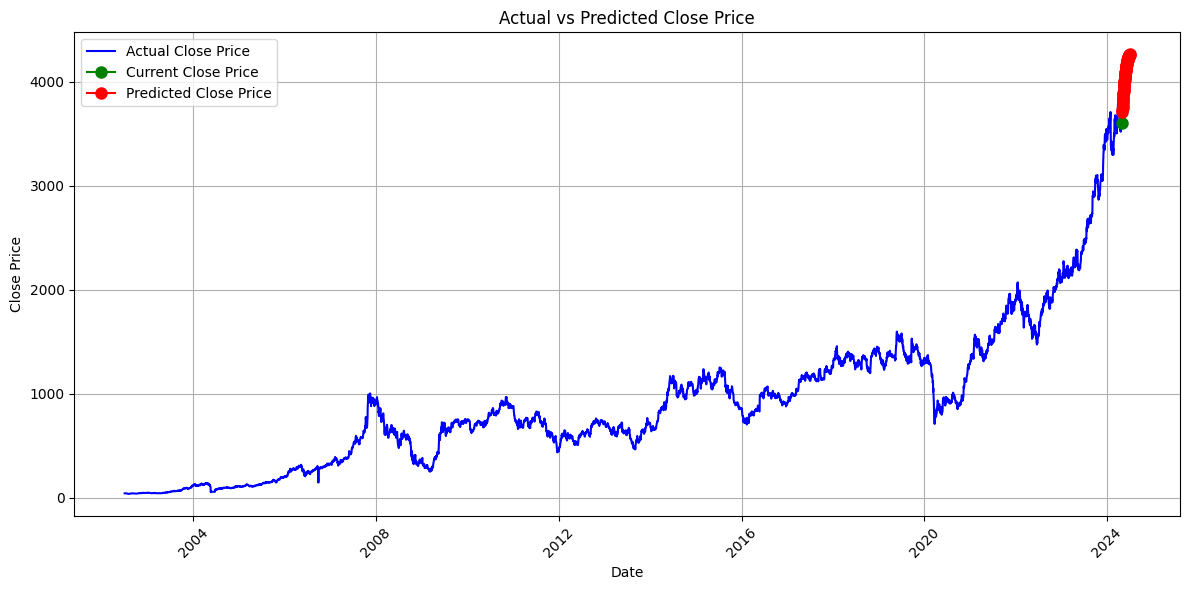

In [14]:
def predict_future_prices(model, data, look_back, num_days):
    last_sequence = data[-look_back:]  # Get the last sequence of known data
    predicted_prices = []
    for _ in range(num_days):
        prediction = model.predict(last_sequence.reshape(1, look_back, 1))  # Predict next day's price
        predicted_prices.append(prediction[0, 0])  # Append predicted price to list
        last_sequence = np.append(last_sequence[1:], prediction[0])  # Update last sequence with new prediction
    return scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))[:, 0]

# Predict future prices for the next 20 days
num_days = 60  # Change this value to predict a different number of days into the future
predicted_prices = predict_future_prices(model, scaled_data, look_back, num_days)

# Plot actual and predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], scaler.inverse_transform(scaled_data), label='Actual Close Price', color='blue')
plt.plot(data['Date'].iloc[-1:], scaler.inverse_transform(scaled_data)[-1:], marker='o', markersize=8, color='green', label='Current Close Price')
plt.plot(pd.date_range(start=data['Date'].iloc[-1], periods=num_days+1, freq='D')[1:], predicted_prices, marker='o', markersize=8, color='red', label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
predicted_prices

array([3709.1453, 3723.4146, 3748.5903, 3775.4526, 3800.1477, 3822.0208,
       3841.5645, 3859.4722, 3876.3145, 3892.4712, 3908.1628, 3923.4912,
       3938.487 , 3953.1387, 3967.4194, 3981.298 , 3994.7498, 4007.7556,
       4020.3074, 4032.4048, 4044.0505, 4055.255 , 4066.0276, 4076.3823,
       4086.3308, 4095.8872, 4105.0635, 4113.873 , 4122.3276, 4130.439 ,
       4138.2188, 4145.6772, 4152.8257, 4159.676 , 4166.2373, 4172.5205,
       4178.5356, 4184.2935, 4189.802 , 4195.0713, 4200.1113, 4204.93  ,
       4209.537 , 4213.941 , 4218.1494, 4222.1694, 4226.0103, 4229.679 ,
       4233.1826, 4236.5283, 4239.722 , 4242.771 , 4245.6816, 4248.459 ,
       4251.1094, 4253.638 , 4256.051 , 4258.353 , 4260.5483, 4262.642 ],
      dtype=float32)

In [16]:
model.save('LT_NS.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
import joblib
joblib.dump(scaler, 'LT_NS_minmax_scaler.pkl')

['LT_NS_minmax_scaler.pkl']